In [1]:
!pip install emoji

     |████████████████████████████████| 185 kB 8.3 MB/s 
  Created wheel for emoji: filename=emoji-1.4.1-py3-none-any.whl size=186393 sha256=0cb38a780b964e27de67029c27ff026f0d9343a72d55160dbf942e57fd05026e
  Stored in directory: /root/.cache/pip/wheels/8e/68/ac/537456a5331f1405779f2b3c2a578429d2f6d7419e440330d8
Successfully built emoji


In [2]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

# Basic functions

In [3]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9][0-9]):([0-9][0-9]) (AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [4]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [5]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

In [7]:
def getDayPart(x):
    if (x > 4) and (x <= 8):
        return 'Early Morning'
    elif (x > 8) and (x <= 12 ):
        return 'Morning'
    elif (x > 12) and (x <= 16):
        return'Noon'
    elif (x > 16) and (x <= 20) :
        return 'Evening'
    elif (x > 20) and (x <= 24):
        return'Night'
    elif (x <= 4):
        return'Late Night'

In [8]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe

conversationPath = 'WhatsAppChat.txt'


with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
         
        line = fp.readline() 
        if not line: 
            break
        line = line.strip()
        if startsWithDateAndTime(line):            
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [9]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.head()

,Date,Time,Author,Message
0,2015-06-25,1:42:12 AM,None,‎You were added
1,2016-12-18,1:57:38 AM,Shahain,<‎image omitted>
2,2016-12-21,9:54:46 PM,Pankaj Sinha,<‎image omitted>
3,2016-12-21,9:57:45 PM,Shahain,Wow
4,2016-12-21,10:48:51 PM,Sakshi,<‎image omitted>


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     390 non-null    datetime64[ns]
 1   Time     390 non-null    object        
 2   Author   357 non-null    object        
 3   Message  390 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 12.3+ KB


Author has few blank data, that can be when someone added/left group, or security messages from WhatsApp itself. 

In [12]:
df.Author.unique()

array([None, 'Shahain', 'Pankaj Sinha', 'Sakshi', 'Neha Wipro', 'Ganguly',
       'Vishnu Gaud', 'Venu Wipro', 'Kushbhu', 'Preeti', 'Mukti Sharma',
       'Shweta', 'Kranthi', 'Sahil Phatania', 'Shradha',
       'Yogesh Raghavan'], dtype=object)

Lets Drop all data with blank Author

In [13]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 1 to 387
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     357 non-null    datetime64[ns]
 1   Time     357 non-null    object        
 2   Author   357 non-null    object        
 3   Message  357 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 13.9+ KB


In [14]:
df.Author.unique()

array(['Shahain', 'Pankaj Sinha', 'Sakshi', 'Neha Wipro', 'Ganguly',
       'Vishnu Gaud', 'Venu Wipro', 'Kushbhu', 'Preeti', 'Mukti Sharma',
       'Shweta', 'Kranthi', 'Sahil Phatania', 'Shradha',
       'Yogesh Raghavan'], dtype=object)

In [15]:
total_messages = df.shape[0]
print(total_messages)

357


We need to check Media messages. We can have image, video, or Media. But my dataset has only images

In [16]:
media_messages = df[df['Message'] == '<‎image omitted>'].shape[0]
print(media_messages)

24


Count 

In [47]:
import emoji

def extract_emojis(s):
  return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'])

df["emoji"] = df["Message"].apply(extract_emojis)
emojis = sum(df['emoji'].str.len())
print(emojis)

648


In [18]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)

In [48]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 357
Media: 24
Emojis: 648
Links: 0


In [49]:
media_messages_df = df[df['Message'] == '<‎image omitted>']

In [50]:
messages_df = df.drop(media_messages_df.index)
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 3 to 387
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      333 non-null    datetime64[ns]
 1   Time      333 non-null    object        
 2   Author    333 non-null    object        
 3   Message   333 non-null    object        
 4   emoji     333 non-null    object        
 5   urlcount  333 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 18.2+ KB


In [51]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [54]:
messages_df.head()

,Date,Time,Author,Message,emoji,urlcount,Letter_Count,Word_Count,MessageCount,emojicount
3,2016-12-21,9:57:45 PM,Shahain,Wow,,0,3,1,1,0
6,2016-12-21,10:50:12 PM,Neha Wipro,Awsum😀😀👍🏼👍🏼,😀😀👍🏼👍🏼,0,11,1,1,6
7,2016-12-21,10:51:21 PM,Sakshi,🙈,🙈,0,1,1,1,1
8,2016-12-21,10:57:01 PM,Ganguly,🙂🙂👍🏻👍🏻,🙂🙂👍🏻👍🏻,0,6,1,1,6
9,2016-12-21,11:28:51 PM,Vishnu Gaud,Waste out of wealth 😂,😂,0,21,5,1,1


In [53]:
messages_df["emojicount"]= df['emoji'].str.len()

In [55]:
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of Shahain -
Messages Sent 72
Words per message 5.833333333333333
Media Messages Sent 2
Emojis Sent 77
Links Sent 1

Stats of Neha Wipro -
Messages Sent 25
Words per message 3.8
Media Messages Sent 1
Emojis Sent 48
Links Sent 0

Stats of Sakshi -
Messages Sent 8
Words per message 16.875
Media Messages Sent 2
Emojis Sent 7
Links Sent 0

Stats of Ganguly -
Messages Sent 4
Words per message 3.5
Media Messages Sent 0
Emojis Sent 8
Links Sent 0

Stats of Vishnu Gaud -
Messages Sent 77
Words per message 5.467532467532467
Media Messages Sent 4
Emojis Sent 80
Links Sent 1

Stats of Venu Wipro -
Messages Sent 5
Words per message 1.8
Media Messages Sent 1
Emojis Sent 0
Links Sent 0

Stats of Kushbhu -
Messages Sent 13
Words per message 39.92307692307692
Media Messages Sent 0
Emojis Sent 90
Links Sent 1

Stats of Preeti -
Messages Sent 36
Words per message 14.527777777777779
Media Messages Sent 9
Emojis Sent 95
Links Sent 0

Stats of Pankaj Sinha -
Messages Sent 32
Words per message 7.875
M

Text(0, 0.5, 'Day')

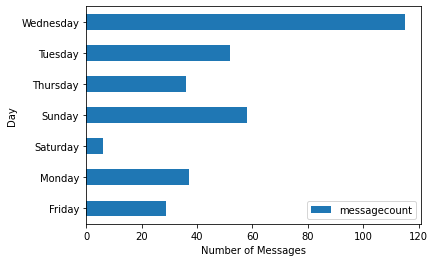

In [56]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum() 
day.plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Day')

Messages by time

In [57]:
messages_df['Hours'] = pd.to_datetime(messages_df['Time']).dt.strftime('%H')

Text(0, 0.5, 'Hours')

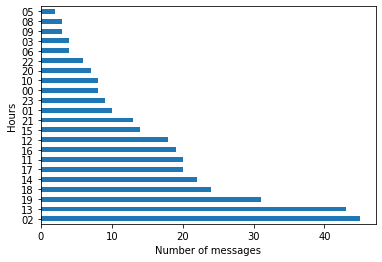

In [58]:
dt = messages_df['Hours'].value_counts()
dt.head(24).plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Hours')

Text(0, 0.5, 'Part of the Day')

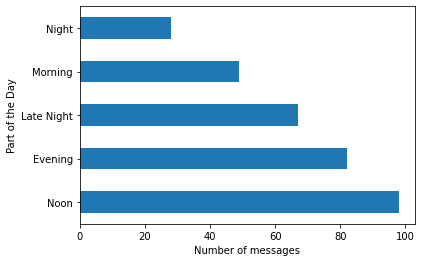

In [31]:
messages_df['DayPart'] = messages_df['Hours'].astype(int).apply(getDayPart)
daypart = messages_df['DayPart'].value_counts()
daypart.head().plot.barh()
plt.xlabel('Number of messages')
plt.ylabel('Part of the Day')

**Messages count by author**

Text(0, 0.5, 'Author')

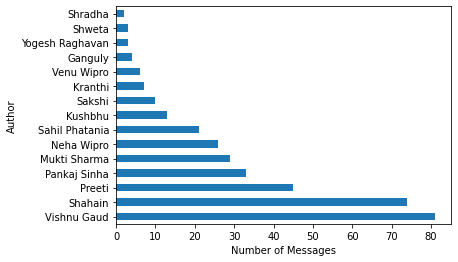

In [65]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
#top_author_value_counts = author_value_counts.head() # Number of messages per author for the top 10 most active authors
author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis
plt.xlabel('Number of Messages')
plt.ylabel('Author')

Vishnu and Shahain are most active users, while Shradha and Shweta are least active users

**Media messages count by author**

Text(0, 0.5, 'Author')

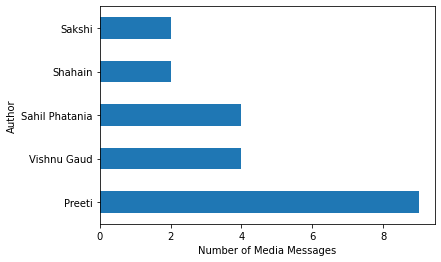

In [33]:
author_media_messages_value_counts = media_messages_df['Author'].value_counts()
top_author_media_messages_value_counts = author_media_messages_value_counts.head()
top_author_media_messages_value_counts.plot.barh()
plt.xlabel('Number of Media Messages')
plt.ylabel('Author')

**Total word count by author**

Text(0, 0.5, 'Authors')

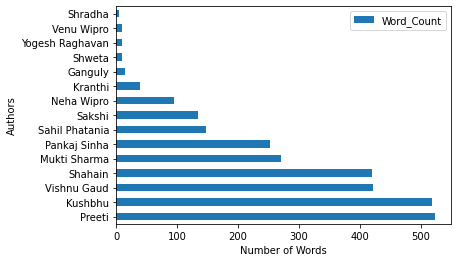

In [64]:
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
#top_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head()
sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

**Most common word count in a message**

Text(0, 0.5, 'Frequency')

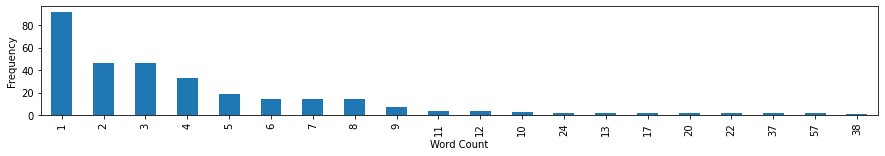

In [35]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_20_word_count_value_counts = word_count_value_counts.head(20)
top_20_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

As we see graph, we can say - People prefers small messages.

**Most common letter count in a message**

Text(0, 0.5, 'Frequency')

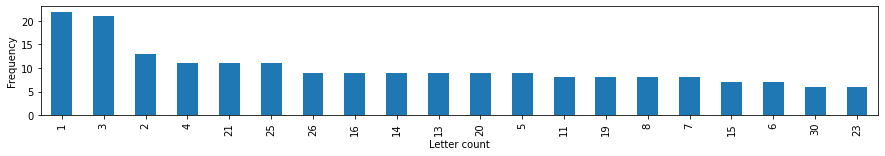

In [37]:
plt.figure(figsize=(15, 2))
letter_count_value_counts = messages_df['Letter_Count'].value_counts()
top_20_letter_count_value_counts = letter_count_value_counts.head(20)
top_20_letter_count_value_counts.plot.bar()
plt.xlabel('Letter count')
plt.ylabel('Frequency')

Although we can say similar about letters, but people have prefered big letter meassages as well

**Most Frequently used word**

Text(0, 0.5, 'Total word Count')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2344 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2361 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2325 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 2352 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 2344 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 2361 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 2325 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backe

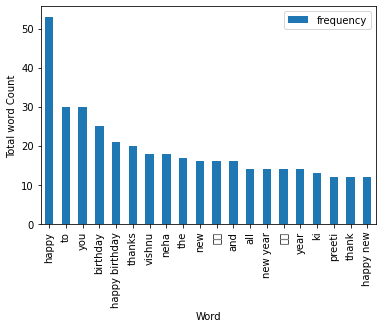

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
word_vectorizer = CountVectorizer(ngram_range=(1,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(messages_df['Message'])
frequencies = sum(sparse_matrix).toarray()[0]
pd1 = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])
pd1.sort_values('frequency',inplace=True,ascending=False)
pd2 = pd1.head(20)
pd2.plot.bar()
plt.xlabel('Word')
plt.ylabel('Total word Count')

We have few hindi text messages exchanged, thats why you are seeing above warning and blank text in graph.

**Emoji Lover**

Text(0, 0.5, 'Authors')

<Figure size 1296x144 with 0 Axes>

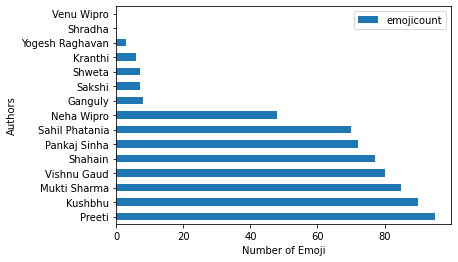

In [62]:
plt.figure(figsize=(18, 2))
total_emoji_by_author = messages_df[['Author', 'emojicount']].groupby('Author').sum()
total_emoji_by_author = total_emoji_by_author.sort_values('emojicount', ascending=False)
total_emoji_by_author.plot.barh()
plt.xlabel('Number of Emoji')
plt.ylabel('Authors')

We can say Preeti is emoji lover, while Shradha dont like emoji.